## Группа 14. Багаутдинов, Богоявленский, Гельмиза

## Парсинг

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import re
import warnings
import time

warnings.filterwarnings("ignore")

browser = webdriver.Safari()   # selenium, чтобы избежать капчи
browser.get('https://auto.ru/cars/used/?page=1')

data = pd.DataFrame({'Модель': [], 
                     'Цена': [], 
                     'Год выпуска': [],
                     'Пробег': [],
                     'Привод': [],
                     'ЛС': [],
                     'Тип двигателя': []
                     , 'Тип кузова': [],
                     'Коробка передач': [],
                     'Объем двигателя': [],
                     'Цвет' : []})

In [74]:
for i in np.arange(100):
    
    html = browser.page_source
    soup = BeautifulSoup(html)
    # парсинг по классам в странице
    other = soup.find_all(attrs={"class":{"ListingItemTechSummaryDesktop__cell"}}) 
    price = soup.find_all(attrs={"class":{"ListingItem__priceBlock"}})
    year = soup.find_all(attrs={"class":{"ListingItem__year"}})
    kmage = soup.find_all(attrs={"class":{"ListingItem__kmAge"}})
    model = soup.find_all(attrs={"class":{"ListingItem__summary"}})
    
    i_hate_sales = 0
    
    for j in np.arange(len(year)):
        # раскладывание парсинга по читаемым категориям
        otherparams = re.sub('\s+','', other[j*5].text).split('/') # некоторые параметры из оставшегося текста        
        data = data.append({'Модель': model[j].a.text,
                             'Цена': re.sub('\W','', price[j].text),
                             'Год выпуска': year[j].text,
                             'Пробег': re.sub('\D','', kmage[j].text),
                             'Привод': other[j*5+3].text,
                             'ЛС': re.sub('\D','', otherparams[1]),
                             'Тип двигателя': re.sub('\s','', otherparams[2]),
                             'Тип кузова': other[j*5+2].text,
                             'Коробка передач': other[j*5+1].text,
                             'Объем двигателя': otherparams[0][:3],
                             'Цвет': other[j*5+4].text}, ignore_index=True)
        
    share = browser.find_element(By.XPATH, "//*[contains(text(), 'Следующая, Cmd ')]")
    share.click() # следующая страница
    time.sleep(5) # ожидание, чтобы успело загрузиться

In [99]:
# вытаскивание нужной цены
data['Цена'] = data['Цена'].apply(lambda x : re.search(r'\d+', x).group())

## Предобработка данных, создание переменных

In [148]:
dt = data.copy(deep = True)

In [149]:
# исправим ошибку в заполнении данных для электрокаров
dt.loc[dt['Тип двигателя'] == 'Электро', 'ЛС'] = dt.loc[dt['Тип двигателя'] == 'Электро']['Объем двигателя']
dt.loc[dt['Тип двигателя'] == 'Электро', 'Объем двигателя'] = np.NaN
dt.loc[dt['Тип двигателя'] == 'Электро', 'Запас хода'] = dt.loc[dt['Тип двигателя'] == 'Электро']['Коробка передач']
dt.loc[dt['Тип двигателя'] == 'Электро', 'Коробка передач'] = np.NaN
# уберём переменные, которые оказались неинформативны/неинтересны
dt = dt.drop('Объем двигателя', axis = 1)
dt = dt.drop('Запас хода', axis = 1)
dt = dt.drop('Тип кузова', axis = 1)
# коробка передача = Nan у электрокаров, хотя вождение их по сути похоже на автомат
dt.fillna('автомат', inplace = True)

In [150]:
pd.DataFrame.drop_duplicates(dt, inplace = True) # дропним дубликаты, поскольку некоторые объявления 

In [151]:
dt.reset_index(drop = True, inplace = True) # новые индексы

In [152]:
# создадим марку
dt['Марка'] = dt['Модель'].str.split(' ').str[0]
dt.loc[dt['Марка'] == 'Land', 'Марка'] = 'Land Rover'

dt['Марка'].value_counts()

Kia              294
BMW              259
Mercedes-Benz    228
Hyundai          136
Toyota           113
                ... 
Aurus              1
Skywell            1
Москвич            1
Bugatti            1
Hummer             1
Name: Марка, Length: 77, dtype: int64

## Описательные статистики и визуализация данных

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

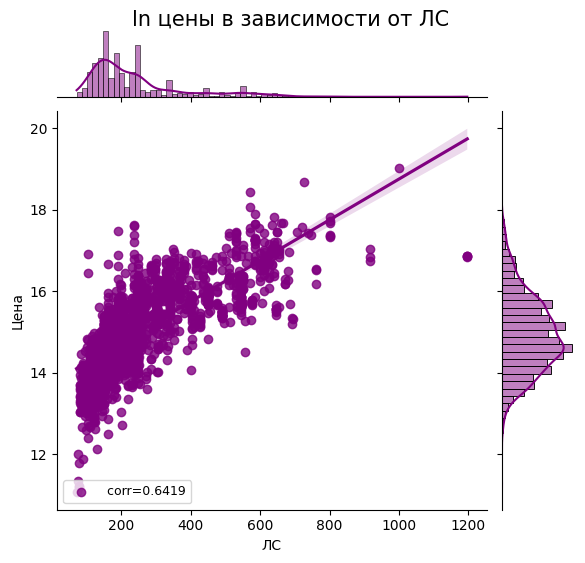

In [15]:
# некоторые взаимосвязи

p = sns.jointplot(data=dt, x = dt['ЛС'], y = np.log(dt['Цена']), kind="reg",
              label = ' corr='
                + str('%.4f' % np.corrcoef(dt['ЛС'], dt['Цена'])[0][1]),color = 'purple')
plt.legend(loc='lower left', fontsize = 9)
p.fig.suptitle('ln цены в зависимости от ЛС', y=0.93, fontsize = 15)
p.fig.subplots_adjust(top=0.90)

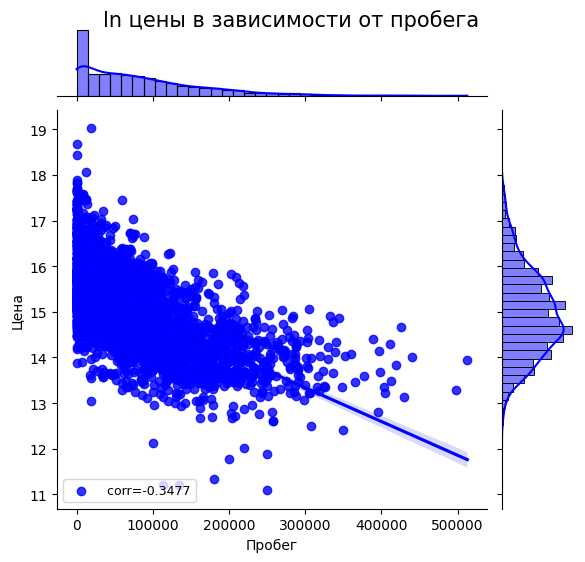

In [17]:
p = sns.jointplot(data=dt, x = dt['Пробег'], y = np.log(dt['Цена']), kind="reg",
              label = ' corr='
                + str('%.4f' % np.corrcoef(dt['Пробег'], dt['Цена'])[0][1]),color = 'b')
plt.legend(loc='lower left', fontsize = 9)
p.fig.suptitle('ln цены в зависимости от пробегa', y=0.93, fontsize = 15)
p.fig.subplots_adjust(top=0.90)

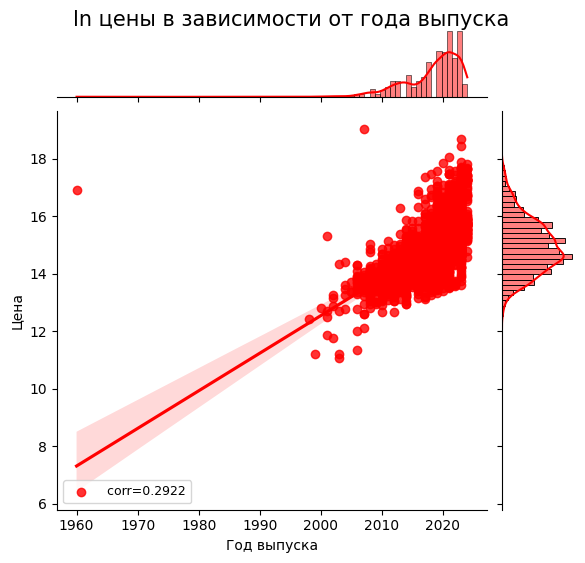

In [18]:
p = sns.jointplot(data=dt, x = dt['Год выпуска'], y = np.log(dt['Цена']), kind="reg",
              label = ' corr='
                + str('%.4f' % np.corrcoef(dt['Год выпуска'], dt['Цена'])[0][1]),color = 'r')
plt.legend(loc='lower left', fontsize = 9)
p.fig.suptitle('ln цены в зависимости от года выпуска', y=0.93, fontsize = 15)
p.fig.subplots_adjust(top=0.90)

(-0.5, 1599.5, 799.5, -0.5)

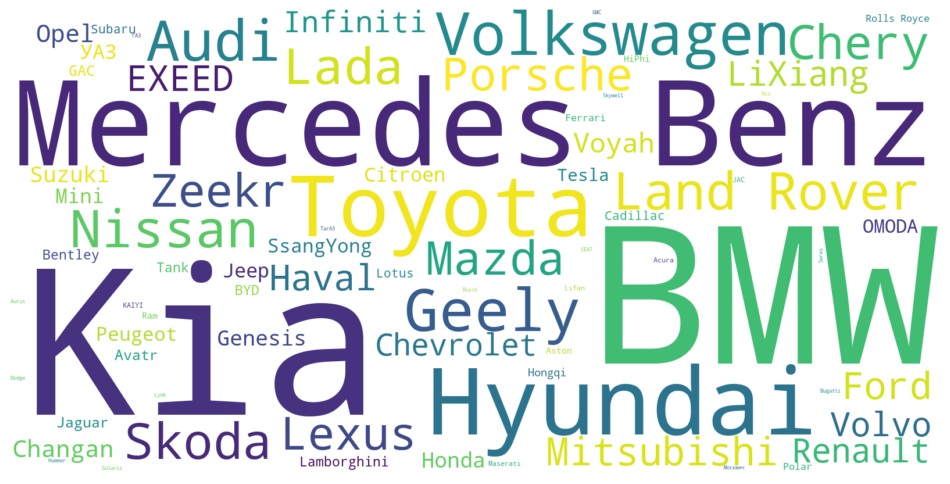

In [20]:
# частота марок

from wordcloud import WordCloud
plt.figure(figsize=(12, 12))
df_string = dt['Марка'].to_string()
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(df_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

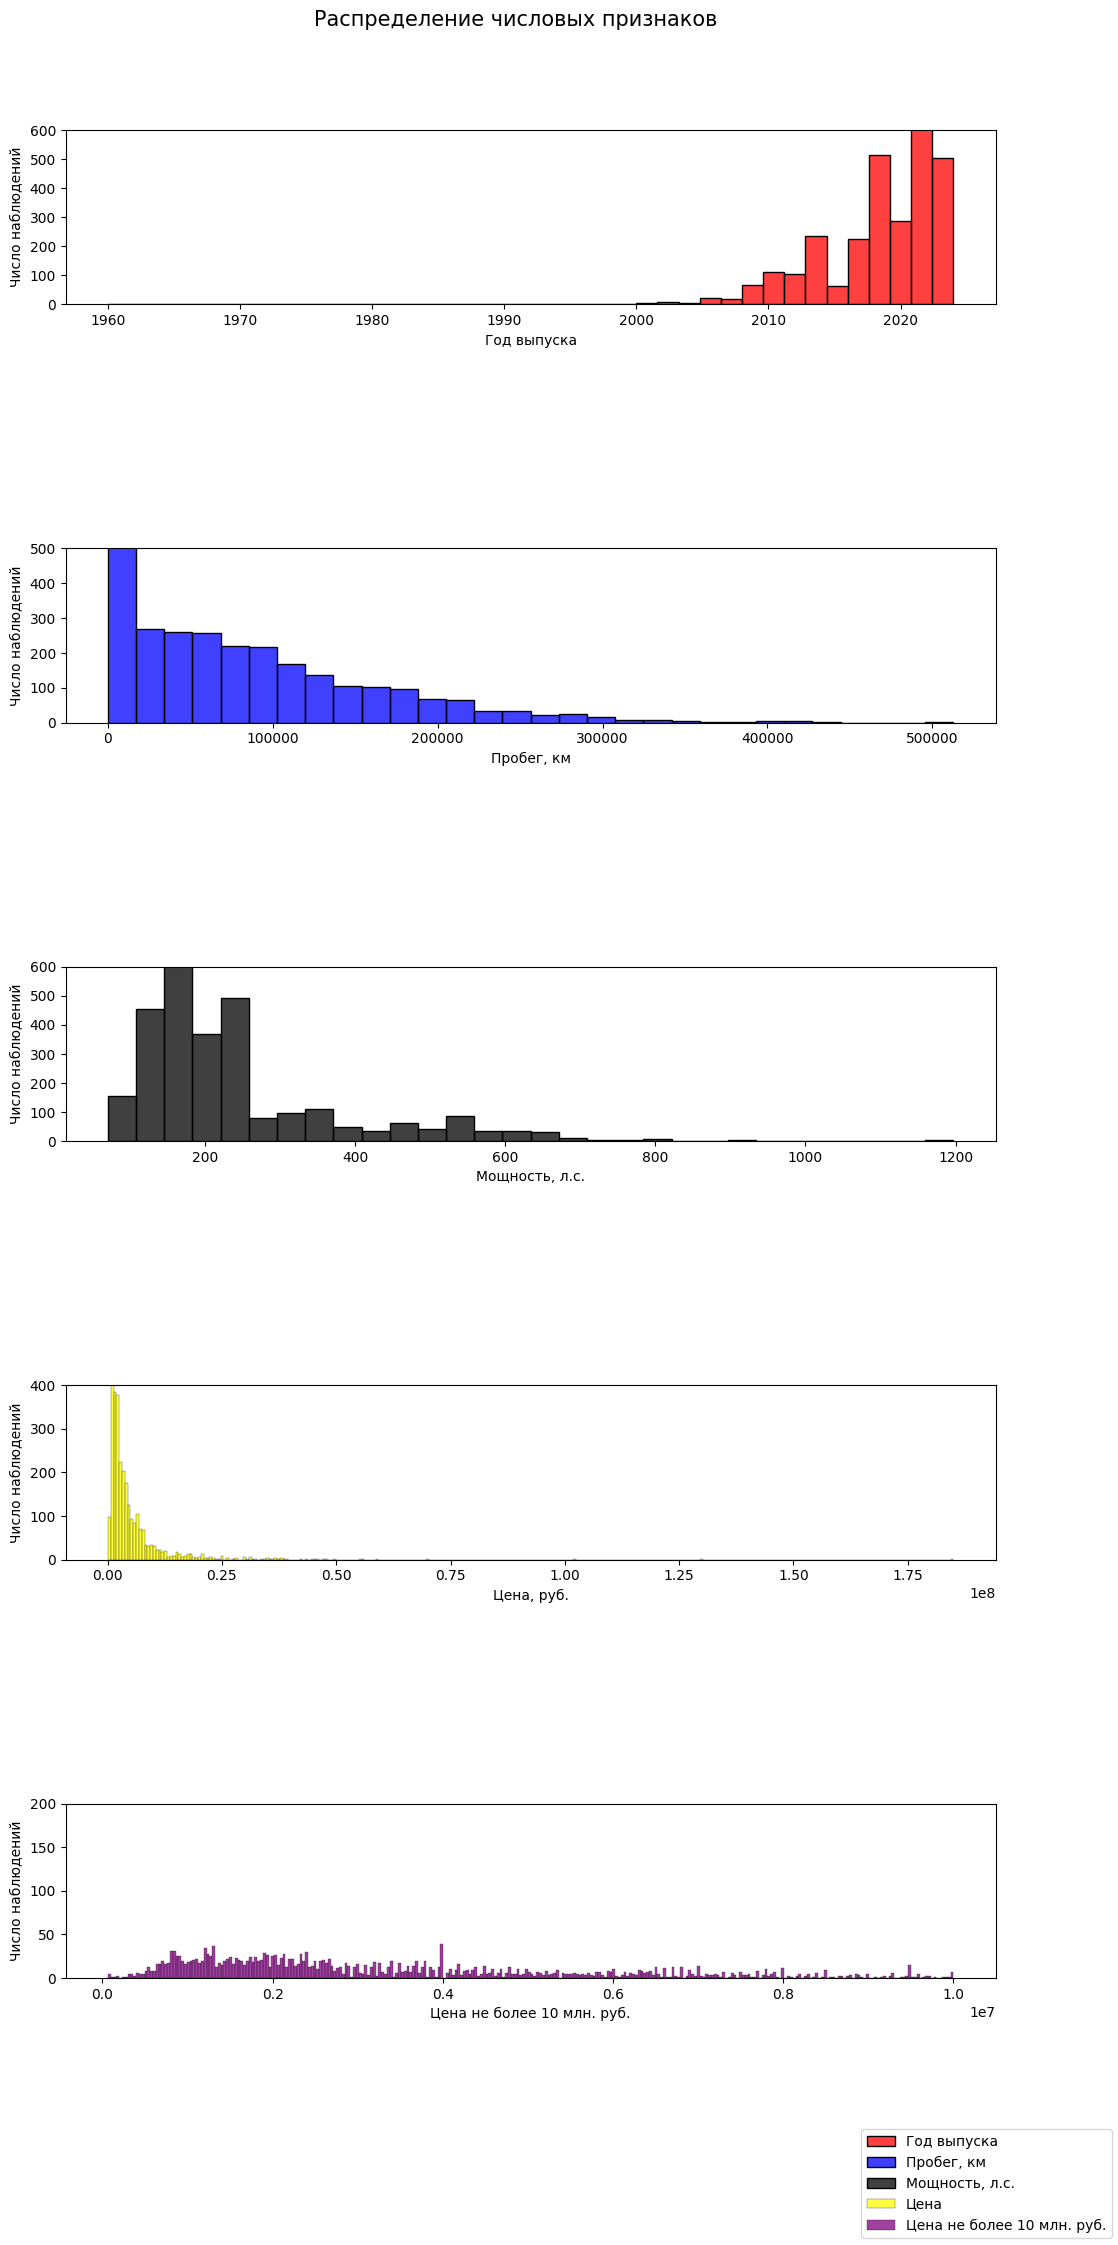

In [24]:
# распределение числовых переменных

fig = plt.figure(figsize=(12, 24))
fig.suptitle('Распределение числовых признаков', y=0.93, fontsize=15)

plt.subplot(9, 1, 1)
sns.histplot(dt['Год выпуска'],
             label = 'Год выпуска', bins = 40, color = 'r').set_ylim(0, 600)

plt.xlabel('Год выпуска')
plt.ylabel('Число наблюдений')

plt.subplot(9, 1, 3)
sns.histplot(dt['Пробег'], 
             label = 'Пробег, км', bins = 30, color = 'b').set_ylim(0, 500)

plt.xlabel('Пробег, км')
plt.ylabel('Число наблюдений')

plt.subplot(9, 1,5)
sns.histplot(dt['ЛС'], 
             label = 'Мощность, л.с.', bins = 30, color = 'black').set_ylim(0, 600)

plt.xlabel('Мощность, л.с.')
plt.ylabel('Число наблюдений')

plt.subplot(9, 1, 7)
sns.histplot(dt['Цена'], 
             label = 'Цена', bins = 300, color = 'yellow').set_ylim(0, 400)

plt.xlabel('Цена, руб.')
plt.ylabel('Число наблюдений')

plt.subplot(9, 1, 9)
sns.histplot(dt[dt['Цена'] <= 10000000]['Цена'], 
             label = 'Цена не более 10 млн. руб.', bins = 300, color = 'purple').set_ylim(0, 200)

plt.xlabel('Цена не более 10 млн. руб.')
plt.ylabel('Число наблюдений')

fig.legend(loc='lower right');

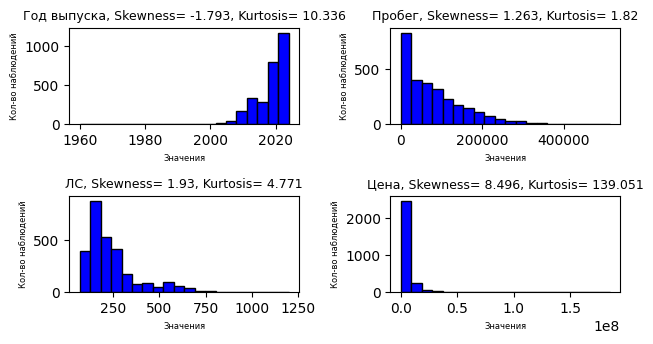

In [27]:
# распределение числовых перменных с коэффицентами

nd = ['Год выпуска','Пробег','ЛС','Цена']
j=0
t=1
from scipy.stats import skew, kurtosis
for i in [1, 5, 10, 15]:
    ax = plt.subplot(3, 2, t)
    ax.hist(dt[nd[j]], bins = 20,
             color = 'blue', edgecolor = 'black')
    ax.set_title(str(nd[j]) + ', Skewness= '+ str(round(skew(dt[nd[j]]), 3)) + 
                 ', Kurtosis= ' 
                 + str(round(kurtosis(dt[nd[j]]),3)), size = 9)
    ax.set_xlabel('Значения', size = 6)
    ax.set_ylabel('Кол-во наблюдений', size= 6)
    j+=1
    t+=1
plt.tight_layout()
plt.show()

In [25]:
# описательные статистики
dt.describe()

,Цена,Год выпуска,Пробег,ЛС
count,2.835000e+03,2835.000000,2835.000000,2835.000000
mean,5.123716e+06,2018.427866,82477.306878,240.000000
std,7.786796e+06,4.526017,78724.875475,142.645436
min,6.500000e+04,1960.000000,1.000000,71.000000
25%,1.614950e+06,2016.000000,17680.000000,149.500000
50%,2.859000e+06,2020.000000,63086.000000,190.000000
75%,5.858500e+06,2022.000000,123721.500000,257.500000
max,1.850000e+08,2024.000000,512809.000000,1197.000000


In [28]:
# корреляции (существенно важных нет, скорее всего нет мультиколлинеарности)

dt[['Год выпуска','Пробег','ЛС','Цена']].corr()

,Год выпуска,Пробег,ЛС,Цена
Год выпуска,1.000000,-0.773847,0.358362,0.292250
Пробег,-0.773847,1.000000,-0.383722,-0.347656
ЛС,0.358362,-0.383722,1.000000,0.641931
Цена,0.292250,-0.347656,0.641931,1.000000


In [29]:
# удаление наиболее очевидных выбросов

dt = dt.loc[dt['Пробег'] < dt['Пробег'].quantile(0.99)]
dt = dt.loc[dt['Год выпуска'] < dt['Год выпуска'].quantile(0.99)]
dt = dt.loc[dt['Цена'] < dt['Цена'].quantile(0.99)]

In [31]:
dt.reset_index(drop = True, inplace = True) # новые индексы
dt

,Модель,Цена,Год выпуска,Пробег,Привод,ЛС,Тип двигателя,Коробка передач,Цвет,Марка
0,Zeekr 001 100 kWh I,6350000,2023,1,полный,544,Электро,автомат,серый,Zeekr
1,Land Rover Range Rover Long IV Рестайлинг,12680000,2021,24766,полный,525,Бензин,автомат,чёрный,Land Rover
2,BMW X6 40i III (G06),9990000,2021,50300,полный,340,Бензин,автомат,чёрный,BMW
3,Mercedes-Benz V-Класс XL 300 d экстра длинный II,29800000,2022,50,полный,237,Дизель,автомат,чёрный,Mercedes-Benz
4,Chery Tiggo 7 Pro I,1908000,2021,43366,передний,147,Бензин,вариатор,чёрный,Chery
...,...,...,...,...,...,...,...,...,...,...
2688,Land Rover Range Rover IV Рестайлинг,6220000,2018,164250,полный,249,Дизель,автомат,серый,Land Rover
2689,Ford Focus III Рестайлинг,945000,2015,117000,передний,150,Бензин,автомат,синий,Ford
2690,Hyundai Sonata VIII (DN8),2300000,2021,67000,передний,150,Бензин,автомат,белый,Hyundai
2691,Skoda Octavia IV (A8),2690000,2021,92957,передний,150,Бензин,автомат,серый,Skoda


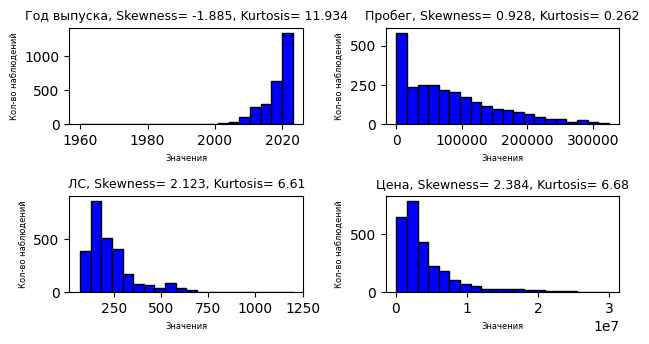

In [32]:
# распределение числовых перменных с коэффицентами после удаление выбросов

nd = ['Год выпуска','Пробег','ЛС','Цена']
j=0
t=1
from scipy.stats import skew, kurtosis
for i in [1, 5, 10, 15]:
    ax = plt.subplot(3, 2, t)
    ax.hist(dt[nd[j]], bins = 20,
             color = 'blue', edgecolor = 'black')
    ax.set_title(str(nd[j]) + ', Skewness= '+ str(round(skew(dt[nd[j]]), 3)) + 
                 ', Kurtosis= ' 
                 + str(round(kurtosis(dt[nd[j]]),3)), size = 9)
    ax.set_xlabel('Значения', size = 6)
    ax.set_ylabel('Кол-во наблюдений', size= 6)
    j+=1
    t+=1
plt.tight_layout()
plt.show()

## Модель

In [35]:
import statsmodels.api as sm

In [36]:
display(dt)

,Модель,Цена,Год выпуска,Пробег,Привод,ЛС,Тип двигателя,Коробка передач,Цвет,Марка
0,Zeekr 001 100 kWh I,6350000,2023,1,полный,544,Электро,автомат,серый,Zeekr
1,Land Rover Range Rover Long IV Рестайлинг,12680000,2021,24766,полный,525,Бензин,автомат,чёрный,Land Rover
2,BMW X6 40i III (G06),9990000,2021,50300,полный,340,Бензин,автомат,чёрный,BMW
3,Mercedes-Benz V-Класс XL 300 d экстра длинный II,29800000,2022,50,полный,237,Дизель,автомат,чёрный,Mercedes-Benz
4,Chery Tiggo 7 Pro I,1908000,2021,43366,передний,147,Бензин,вариатор,чёрный,Chery
...,...,...,...,...,...,...,...,...,...,...
2688,Land Rover Range Rover IV Рестайлинг,6220000,2018,164250,полный,249,Дизель,автомат,серый,Land Rover
2689,Ford Focus III Рестайлинг,945000,2015,117000,передний,150,Бензин,автомат,синий,Ford
2690,Hyundai Sonata VIII (DN8),2300000,2021,67000,передний,150,Бензин,автомат,белый,Hyundai
2691,Skoda Octavia IV (A8),2690000,2021,92957,передний,150,Бензин,автомат,серый,Skoda


Построить эконометрические модели для цены товара. Подобрать функциональную форму, набор объясняющих переменных, проверить предпосылки теоремы Гаусса-Маркова и гипотезы о нормальности случайной ошибки. Проверить гипотезы о значимости коэффициентов и модели в целом. Выбрать наилучшую модель. Все выводы должны быть тщательно обоснованы количественно.

Введем дамми-переменные для категориальных признаков:

In [39]:
dt2 = pd.get_dummies(dt, columns=["Привод", "Тип двигателя", "Коробка передач", "Цвет", "Марка"], drop_first=False)

### Выбор модели

#### линейная модель без константы 

In [40]:
x = (dt2.drop(columns=["Цена", "Модель"]))  
y = dt2["Цена"]

lin_model_noconst = sm.OLS(y, x).fit()

print(lin_model_noconst.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     104.4
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:56:35   Log-Likelihood:                -42931.
No. Observations:                2693   AIC:                         8.606e+04
Df Residuals:                    2596   BIC:                         8.663e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Год выпуска             

#### линейная модель с константой

In [41]:
x_lin = sm.add_constant(dt2.drop(columns=["Цена", "Модель"]))  
 
y_lin = dt2["Цена"]

lin_model = sm.OLS(y_lin, x_lin).fit()

print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     104.4
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:56:38   Log-Likelihood:                -42931.
No. Observations:                2693   AIC:                         8.606e+04
Df Residuals:                    2596   BIC:                         8.663e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### полулогарифмическая модель с константой

In [42]:
x_halflog = sm.add_constant(dt2.drop(columns=["Цена", "Модель"]))  

y_halflog = np.log(dt2["Цена"])

halflog_model = sm.OLS(y_halflog, x_halflog).fit()

print(halflog_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     299.7
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:56:45   Log-Likelihood:                -146.77
No. Observations:                2693   AIC:                             487.5
Df Residuals:                    2596   BIC:                             1060.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### логарифмическая модель с константой

In [43]:
x_log = sm.add_constant(dt2.drop(columns=["Цена", "Модель"]))  

y_log = np.log(dt2["Цена"])

x_log["ln_Пробег"] = np.log(dt2["Пробег"])

x_log = x.drop(columns=["Пробег"])

log_model = sm.OLS(y_log, x_log).fit()

print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     245.2
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        17:56:48   Log-Likelihood:                -405.89
No. Observations:                2693   AIC:                             1004.
Df Residuals:                    2597   BIC:                             1570.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Год выпуска             

### Выбор модели

PE-test не понадобился, так как обнаружилось, что лин модель выдает отрицательные знач

In [44]:
len(np.where(lin_model.fittedvalues < 0)[0])

175

По R-квадрату полулог лучше

Выбираем полулогарифмическую модель с константой

Запись формулы цены:

$
ln(цена) = -64.4810 + 0.0682 \cdot Год \ выпуска - 0.00000273 \cdot Пробег + 0.0299 \cdot ЛС 
+ \alpha_{i} \cdot Привод_{i} + ... +  \alpha_{j} \cdot Привод_{j} + \gamma_{i} \cdot Тип \ двигателя_{i} + ... + \gamma_{j} \cdot Тип \ двигателя_{j} + \kappa_{i} \cdot Коробка \ передач_{i} + ... + \kappa_{j} \cdot Коробка \ передач_{j} + \lambda_{i} \cdot Цвет_{i} + ... + \lambda_{j} \cdot Цвет_{j} + \psi{i} \cdot Марка_{i} + ... + \psi{j}\cdot Марка_{j} 
$

### Проверка на выбросы 

In [46]:
# выбросы через студ остатки

from scipy import stats
influence = halflog_model.get_influence()
student_resid = influence.resid_studentized_external
crit = stats.t(2693 - 96).ppf((0.99))
tm = pd.DataFrame((x_halflog[abs(student_resid) > crit]))
vyb = tm.index.values
len(x.loc[tm.index.values])

49

### Предпосылки теоремы Гаусса-Маркова

#### Проверка на гетероскедастичность

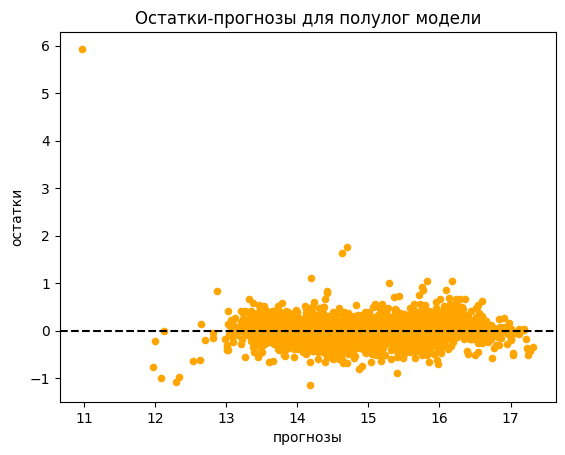

In [47]:
# остатки - прогнозы

res = halflog_model.resid
pred_values = halflog_model.fittedvalues


res_pred_values = pd.DataFrame({"прогнозы": pred_values, "остатки": res})


res_pred_values.plot(kind="scatter", title = "Остатки-прогнозы для полулог модели", x ="прогнозы", y="остатки", color = "orange")

plt.axhline(color="black", linestyle="dashed")

In [48]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

gq_test = het_goldfeldquandt(halflog_model.resid, halflog_model.model.exog)


gq_p_value_gq = gq_test[1]



print("Goldfeld-Quandt Test p-value:", gq_p_value_gq)

if gq_p_value_gq < 0.05:
    print("H0 отвергается. Есть гетероскедастичность.")
else:
    print("Нет оснований отвергать H0. Есть гомоскедастичность.")

Goldfeld-Quandt Test p-value: 0.9999999996154841
Нет оснований отвергать H0. Есть гомоскедастичность.


#### Проверка на мультиколлинеарность

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

[variance_inflation_factor(x_halflog.values, i) for i in range(1,x_halflog.shape[1])]

[3.041703719313102,
 2.8292295385384834,
 3.6786680394343048,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

#### Проверка на автокорреляцию

In [59]:
from statsmodels.stats.stattools import durbin_watson

dw_statistic = durbin_watson(halflog_model.resid)

print("Статистика Дарбина-Уотсона:", dw_statistic)


if dw_statistic < 1.5:
    print("Положительная автокорреляция.")
elif dw_statistic > 2.5:
    print("Отрицательная автокорреляция.")
else:
    print("Автокорреляция отсутсвует.")

Статистика Дарбина-Уотсона: 1.944640285380239
Автокорреляция отсутсвует.


#### Проверка на нормальность остатков

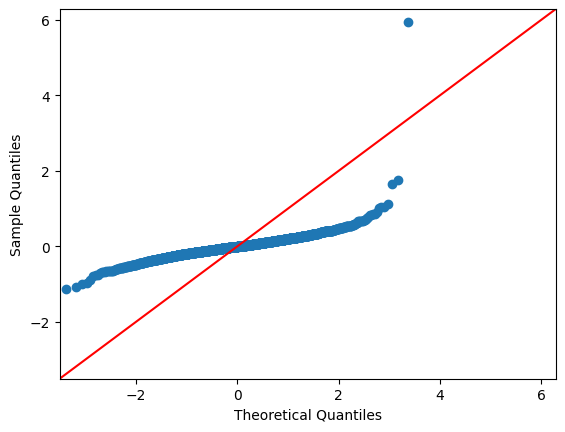

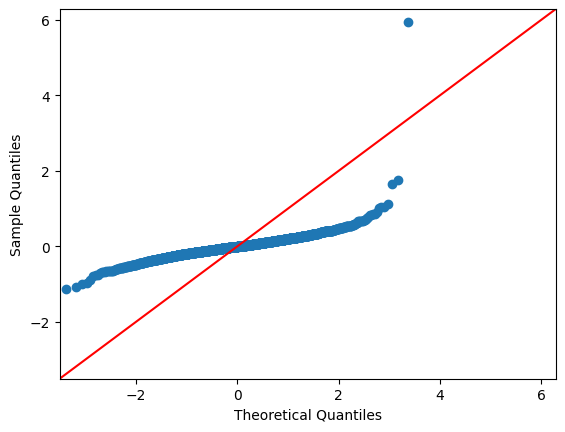

In [50]:
sm.qqplot(halflog_model.resid, line = '45')

In [51]:
np.mean(halflog_model.resid)

3.280958126794994e-12

### Качество модели

In [52]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_error(pred_values, y_halflog), 
mean_squared_error(pred_values, y_halflog),
mean_absolute_percentage_error(pred_values, y_halflog))

0.17000421415131262 0.06529286200472904 0.011506309942292582


### Предсказание по модели

Проверяемый товар - BMV, бензиновый двигатель, задний привод, автомат, синий, 184 лс, 2019 год выпуска, пробег 100000 км. 

In [61]:
y_price_bmw = -64.4810 + (0.0682  * 2019) + (-2.733e-06 * 100000) + (0.0029  * 190) + (-21.4376) + (-16.1126) + (-16.0742) + (-4.3215) + (-0.5214)

np.exp(y_price_bmw) 

3352443.36288083

Цена подобной на авто.ру - 3290000 руб. 

### Другая модель

Для борьбы с выбросами, выбрали квантильную регрессию

In [56]:
x_q = dt2.drop(columns=["Цена", "Модель"])
 
y_q = np.log(dt2["Цена"])

q_model = sm.regression.quantile_regression.QuantReg(y_q, x_q).fit(q=0.90)

print(q_model.summary())

                         QuantReg Regression Results                          
Dep. Variable:                   Цена   Pseudo R-squared:               0.6987
Model:                       QuantReg   Bandwidth:                     0.08346
Method:                 Least Squares   Sparsity:                        1.120
Date:                Fri, 10 May 2024   No. Observations:                 2693
Time:                        18:17:15   Df Residuals:                     2596
                                        Df Model:                           96
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Год выпуска                  0.0071   2.45e-05    290.920      0.000       0.007       0.007
Пробег                   -4.011e-06   1.42e-07    -28.178      0.000   -4.29e-06   -3.73e-06
ЛС                           0.0043    8.2e-05     52.336      0.000       

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [57]:
qpred_values = q_model.fittedvalues
print(mean_absolute_error(qpred_values, y_q),   
mean_squared_error(qpred_values, y_q),
mean_absolute_percentage_error(qpred_values, y_q))

0.3716190220637916 0.24171971022603808 0.02428791025022921
